In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

from pywave.energy_transport.advect_atten1d import AdvectAtten1D

In [2]:
def init_shape(x, x0=15, shape="step"):
    if shape == "gaussian":
        std = 4
        return np.exp(-pow((x-x0)/std, 2)/2)

    out = np.ones_like(x)
    out[x>x0+10] = 0
    if shape == "step_topup":
        #step ...|__
        return out
    
    # finite step __|...|__
    out[x<x0-10] = 0
    return out

In [3]:
def plot_step(x, u, c, alpha, n, dt, outdir=None, **kwargs):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x, u, '--')
    t = n * dt
    exact = init_shape(x - c * t, **kwargs) * np.exp(-alpha*t)
    ax.plot(x, exact, 'r')
    ax.set_title(f't = {t}s')
    ax.set_xlabel('x, m')
    ax.set_ylabel('c')
    if outdir is None: return
    figname = '%s/adv%2.2i.png' %(outdir, n)
#     print(f'Saving {figname}')
    fig.savefig(figname)

In [4]:
def run(adv, u0, c, alpha, x, outdir=None, **kwargs):
    if outdir is not None:
        print(f'Saving figs in {outdir}')
        os.makedirs(outdir, exist_ok=True)
        #plot initial conditions
        plot_step(x, u0, c, alpha, 0,  adv.dt, outdir, **kwargs)
        u = np.copy(u0)
        for n in range(50):
            plt.close()
            u = adv.adv_atten(u, c, alpha)
            plot_step(x, u, c, alpha, n+1,  adv.dt, outdir=outdir, **kwargs)

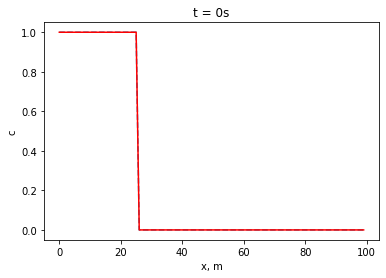

In [5]:
cfl = .9
dx = 1
dt = 1
alpha = .1
c, x0 = cfl*dx/dt, 15 # advect left to right
# c, x0 = -cfl*dx/dt, 85 # advect right to left
x = np.arange(100)*dx
shape = "step_topup"
# shape = "gaussian"
kw_init=dict(shape=shape, x0=x0)
u0 = init_shape(x, **kw_init)
plot_step(x, u0, c, alpha, 0,  dt, **kw_init)

Saving figs in figs_fou


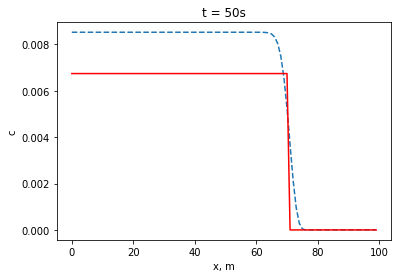

In [6]:
adv = AdvectAtten1D(dx, dt, scheme='first_order_upwind', u_correction_scheme="implicit")
run(adv, u0, c, alpha, x, outdir='figs_fou', **kw_init)

Saving figs in figs_fou


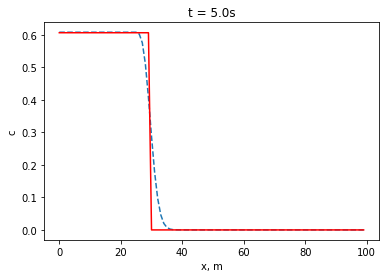

In [7]:
# reduce time step to better capture attenuation
adv = AdvectAtten1D(dx, dt/10, scheme='first_order_upwind', u_correction_scheme="implicit")
run(adv, u0, c, alpha, x, outdir='figs_fou', **kw_init)

# Lax-Friedrichs

Saving figs in figs_lf


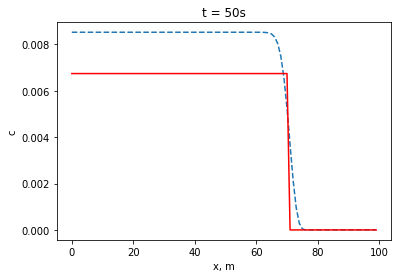

In [8]:
adv = AdvectAtten1D(dx, dt,
                    scheme='lax_friedrichs',
                    u_correction_scheme="implicit",
                   )
run(adv, u0, c, alpha, x, outdir='figs_lf', **kw_init)

Saving figs in figs_lf


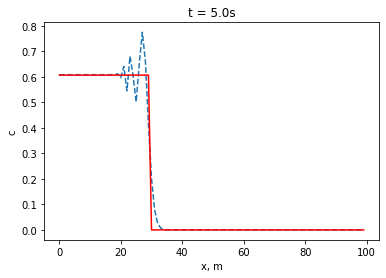

In [9]:
# reduce time step to better capture attenuation
adv = AdvectAtten1D(dx, dt/10,
                    scheme='lax_friedrichs',
                    u_correction_scheme="implicit",
                   )
run(adv, u0, c, alpha, x, outdir='figs_lf', **kw_init)

Saving figs in figs_lf


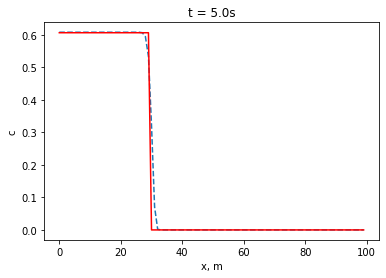

In [10]:
# add superbee flux limiting
adv = AdvectAtten1D(dx, dt/10,
                    scheme='lax_friedrichs',
                    u_correction_scheme="implicit",
                    limiter="superbee",
                   )
run(adv, u0, c, alpha, x, outdir='figs_lf', **kw_init)

# Lax-Wendroff
- prediction-correction scheme
  - predict with Lax-Friedrichs
  - later correct

Saving figs in figs_lw


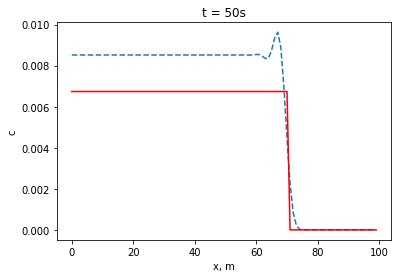

In [11]:
adv = AdvectAtten1D(dx, dt, scheme='lax_wendroff',
                    flux_correction_scheme=None,
                    u_correction_scheme="implicit")
run(adv, u0, c, alpha, x, outdir="figs_lw", **kw_init)

Saving figs in figs_lw


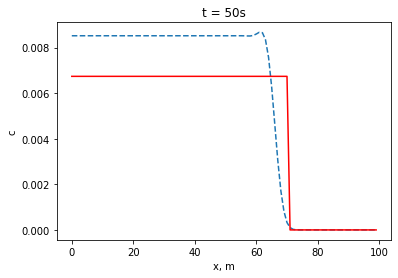

In [12]:
# correct the predicted flux to allow for attenuation
# - smaller jump behind the front, but front moves a bit slower
adv = AdvectAtten1D(dx, dt, scheme='lax_wendroff',
                    flux_correction_scheme="implicit",
                    u_correction_scheme="implicit")
run(adv, u0, c, alpha, x, outdir="figs_lw", **kw_init)

Saving figs in figs_lw


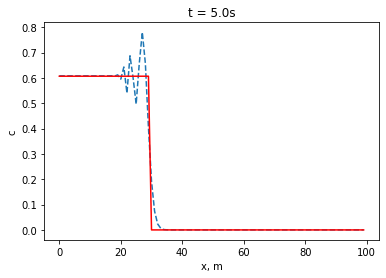

In [13]:
# reduce time step to capture attenuation better
adv = AdvectAtten1D(dx, dt/10, scheme='lax_wendroff',
                    flux_correction_scheme="implicit",
                    u_correction_scheme="implicit")
run(adv, u0, c, alpha, x, outdir="figs_lw", **kw_init)

Saving figs in figs_lw_vl


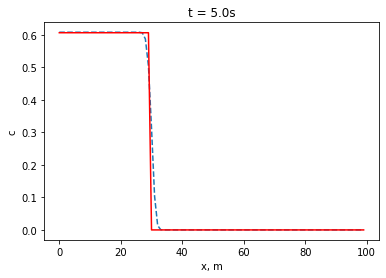

In [14]:
# add van Leer flux limiting to remove oscillations
adv = AdvectAtten1D(dx, dt/10, scheme='lax_wendroff',
                    limiter='van_leer',
                    flux_correction_scheme="implicit",
                    u_correction_scheme="implicit",
                   )
run(adv, u0, c, alpha, x, outdir="figs_lw_vl", **kw_init)

Saving figs in figs_lw_vl


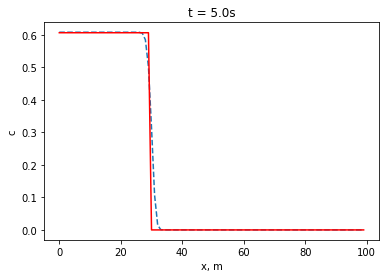

In [15]:
# with flux limiting don't need flux correction
adv = AdvectAtten1D(dx, dt/10, scheme='lax_wendroff',
                    limiter='van_leer',
                    flux_correction_scheme=None,
                    u_correction_scheme="implicit",
                   )
run(adv, u0, c, alpha, x, outdir="figs_lw_vl", **kw_init)

Saving figs in figs_lw_sb


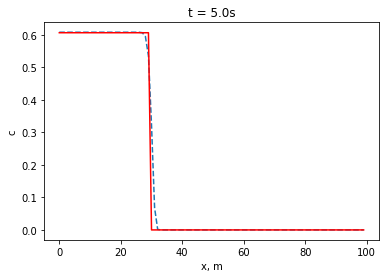

In [16]:
# can also use superbee flux limiting to remove oscillations
# - bit better than van Leer
# - no flux correction
adv = AdvectAtten1D(dx, dt/10, scheme='lax_wendroff',
                    limiter='superbee',
                    flux_correction_scheme=None,
                    u_correction_scheme="implicit",
                   )
run(adv, u0, c, alpha, x, outdir= 'figs_lw_sb', **kw_init)

Saving figs in figs_lw_sb


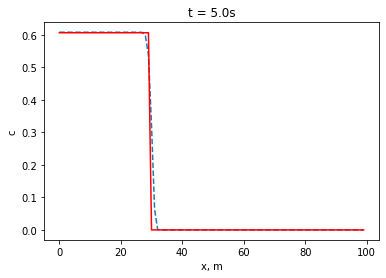

In [17]:
# can also add superbee flux limiting to remove oscillations
# - bit better than van Leer
# - again flux correction makes little difference with flux limiting
adv = AdvectAtten1D(dx, dt/10, scheme='lax_wendroff',
                    limiter='superbee',
                    flux_correction_scheme="implicit",
                    u_correction_scheme="implicit",
                   )
run(adv, u0, c, alpha, x, outdir= 'figs_lw_sb', **kw_init)